# Notebook used to: 
## - prepare the CMEMS hist048 data (i.e., create pickle files of the dataset organized by year). 
## - Also used to create a polygon representing the intersection between the polygons in the OPP report and the 1000m bathymetry contour

### relevant files:
- directory: C:\Users\HoldenJe\Drift\projects\gridded_velocity_products\drifter_data\bathymetry
- picked masterdf containing all CMEMS drifter tracks: cmems_hist048_masterdf.pkl
- pickled CMEMS drifter tracks organized into a dictionary with years as keys: yearly_df_dict.pkl
- yearly pickled files:
  - all data per year: yearly_pickled_files/
  - in/out points and summary strings per year: pickles_yearly_inpts_and_outpts
  
### bathymetry:
- original bathymetry file: ETOPO1_Bed_g_gmt4.grd
- bathymetry data that has be subsetted to our test area: bathy_subset.nc (plots faster and removes out of memory errors)

### polygon definition files:
- bathy_polygons_all_contours.yaml
- OPP_drifter_report_regions_NL_LAB_shelves.yml

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import cm as cmlab
import numpy as np
import os
import pandas as pd
import pickle
import pylab as pl
from shapely.geometry import Point, Polygon
import xarray as xr
%matplotlib inline
from IPython.display import Markdown as md
from IPython.display import HTML
import cmd
import shutil
import yaml
import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.patches as patches
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
cli = cmd.Cmd()
matplotlib.use('Agg')

def create_pickle_file(picklefile, data):
    with open(picklefile,'wb') as f:
        pickle.dump(data, f)
        

def load_pickle_file(picklefile):
    with open(picklefile,'rb') as f:
        data = pickle.load(f)
    return data


def convert_coords_to_tuples(coords):
    if isinstance(coords, LatLonBoundingBox):
        coords_tuples = determine_shelf_edges(coords)
    else:
        coords_tuples = [tuple(l) for l in coords]
        coords_tuples = [(p[1], p[0]) for p in coords_tuples]
    return coords_tuples


def summary_str(smval, bigval):
    perc = "{:.1f}".format((smval / bigval) * 100)
    percstr = (str(smval) + ' of ' + str(bigval) + ' points are in the region (' + str(perc) + '%)')
    return percstr


def determine_shelf_edges(shelf_coords):
    shelf_edges = [(shelf_coords.maxlon, shelf_coords.maxlat), (shelf_coords.maxlon, shelf_coords.minlat),
                   (shelf_coords.minlon, shelf_coords.minlat), (shelf_coords.minlon, shelf_coords.maxlat),
                   (shelf_coords.maxlon, shelf_coords.maxlat)]
    return shelf_edges


def load_polygons(polygons_file):
    """ load the yaml file containing polygon definitions"""

    # load the polygon files from the config file
    with open(polygons_file, 'r') as f:
        polygons = yaml.load(f, Loader=yaml.FullLoader)
    return polygons


def point_outside_polygon(pt, poly):
    point = Point(pt)
    #bool_within = point.within(poly) 
    #return(bool_within)
    if not point.within(poly):
        return True
    else:
        return False
    

def find_poly_extremes(coords):
    plons = [p[0] for p in coords]
    plats = [p[1] for p in coords]
    return LatLonBoundingBox(minlon=min(plons), maxlon=max(plons), 
                             minlat=min(plats), maxlat=max(plats))


def new_exclude_by_outside_extremes(df, poly):
    bbox = find_poly_extremes(poly)
    df.loc[(df['pip'] == False), 'pip'] = True
    df.loc[(df['lons'] < (bbox.minlon)), 'pip'] = False 
    df.loc[(df['lons'] > (bbox.maxlon)), 'pip'] = False
    df.loc[(df['lats'] < (bbox.minlat)), 'pip'] = False
    df.loc[(df['lats'] > (bbox.maxlat)), 'pip'] = False
    percstr = summary_str(len(df['pip'][df['pip'].values].values), len(df['pip'].values))
    return percstr, df
    
    
def new_exclude_by_outside_polygon(df, poly):
    lons = df.lons.values
    lats = df.lats.values
    df.loc[[point_outside_polygon(point, Polygon(poly)) for point in zip(lons, lats)], 'pip'] = False
    percstr = summary_str(len(df['pip'][df['pip'].values]), len(df['pip']))
    return percstr, df


def new_toss_outside(df, coords, exclude_type='fast', verbose=False):
    percstr, df = new_exclude_by_outside_extremes(df, coords)
    sum_str = ('\n' + percstr + ' after removing any points smaller or larger than the polygon extremes')
    if exclude_type == 'slow':    
        percstr, df = new_exclude_by_outside_polygon(df, coords)
        sum_str = (sum_str + '\n' + percstr + ' after also removing any points outside the actual polygon\n')
    if verbose:
        print(sum_str)
    return df, sum_str


def get_points_in_and_out(action='load', df=None, poly_coords=None, exclude_type='fast', 
                          verbose=True, inpickle=None, outpickle=None, sumpickle=None, allpickle=None):
    if action == 'load':
        ptsindf = load_pickle_file(inpickle)
        ptsoutdf = load_pickle_file(outpickle)
        alldf = load_pickle_file(allpickle)
        if verbose:
            summary_str = load_pickle_file(summary_str_pickle)
            print(summary_str)
    else:
        ndf, summary_str = new_toss_outside(df, poly_coords, exclude_type=exclude_type, verbose=verbose)
        ptsindf = ndf.loc[df['pip'].values] 
        ptsoutdf = ndf.loc[df['pip'].values == False]
        create_pickle_file(inpickle, ptsindf)
        create_pickle_file(outpickle, ptsoutdf)
        create_pickle_file(allpickle, ndf)
        create_pickle_file(sumpickle, summary_str)
    return ptsindf, ptsoutdf, ndf

# Organize the CMEMS data in a dictionary by year

In [2]:
def create_df_per_year_dict(df, yrpicklefile):
    years = np.unique(pd.to_datetime(df['times']).dt.year)
    df['times'] = pd.to_datetime(df['times'].values)
    df_year_dict = {}
    for yr in years:
        yeardf = df.loc[df['times'].dt.year == yr]
        df_year_dict[yr] = yeardf
    create_pickle_file(yrpicklefile, df_year_dict)
    return df_year_dict

drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/"
bathydir = os.path.join(drifter_dir, 'bathymetry')
LatLonBoundingBox = collections.namedtuple('LatLonBoundingBox', ('minlon', 'maxlon', 'minlat', 'maxlat'))
picklefile_masterdf = os.path.join(bathydir, 'CMEMS_hist048' + '_masterdf.pkl')
masterdf = load_pickle_file(picklefile_masterdf)
yearly_df_dict_create = create_df_per_year_dict(masterdf, os.path.join(bathydir, 'yearly_df_dict_create.pkl'))

# Define the relevant paths, load the masterdf and yearly_df_dict pickle files, and create the list of points that define the merged polygon:

In [3]:
drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/"
bathydir = os.path.join(drifter_dir, 'bathymetry')
LatLonBoundingBox = collections.namedtuple('LatLonBoundingBox', ('minlon', 'maxlon', 'minlat', 'maxlat'))

# load the bathy polygon coordinates from file and convert them to a list of tuples
bathy_polygons_yml_filename = os.path.join(bathydir, 'contour_1000_polygons.yaml')
f = open(bathy_polygons_yml_filename, 'r')
ym = yaml.load(f, Loader=yaml.FullLoader)
contour1000 = convert_coords_to_tuples(ym['polygon_coords']['contour_1000'])

# load the shelf polygon coordinates and convert them to a list of tuples
shelf_coords = LatLonBoundingBox(minlon=-65, maxlon=-42, minlat=42, maxlat=62)
shelf = convert_coords_to_tuples(shelf_coords)

# load the polygons from the OPP drifter report
OPP_polygons_file = os.path.join(bathydir, 'OPP_drifter_report_regions_NL_LAB_shelves.yml')
OPP_coords = load_polygons(OPP_polygons_file)
OPPpolys = convert_coords_to_tuples(OPP_coords['polygon_coords']['Newfoundland and Labrador'])

# Extract the point values that define the perimeter of the intersection between
# the OPP combined polygon and the 1000m bathy contour polygon
ipoly = Polygon(OPPpolys).intersection(Polygon(contour1000))
ilons, ilats = ipoly.exterior.coords.xy
intpoly = list(zip(list(ilons), list(ilats)))

# load the masterdf and organized by yeardf pickle files: 
#picklefile_masterdf = os.path.join(bathydir, 'CMEMS_hist048' + '_masterdf.pkl')
#masterdf = load_pickle_file(picklefile_masterdf)
picklefile_yearly = os.path.join(bathydir, 'yearly_df_dict.pkl')
yearly_df_dict = load_pickle_file(picklefile_yearly)

# To create pickled files of points that are inside and outside the merged polygon

Note: This took approximately 2 hours to run from 2002-2023 using `exclude_type = 'slow'`. This option first removes points that fall outside the extremes of the polygon area, then checks the remaining points individually to see if they are in or out of the area. This is definitely not optimized for speed since checking each point is very inefficient. But, it's not something that we should have to run frequently enough to be worth optimizing at the moment.

In [4]:
def create_yearly_inpts_and_outpts_pickle_files(yearly_df_dict, pdir):
    pickle_output_dir = os.path.join(pdir, 'pickles_yearly_inpts_and_outpts')
    years = list(yearly_df_dict.keys())
    for yr in years:
        print('\ncreating pickle files for ' + str(yr))
        inpickle = os.path.join(pickle_output_dir, 'points_inside_' + str(yr) + '.pkl')
        outpickle = os.path.join(pickle_output_dir, 'points_outside_' + str(yr) + '.pkl')
        sumpickle = os.path.join(pickle_output_dir, 'summary_str_' + str(yr) + '.pkl')
        allpickle = os.path.join(pickle_output_dir, 'points_all_' + str(yr) + '.pkl')
        
        ptsindf, ptsoutdf, alldf = get_points_in_and_out(
            action='create', df=yearly_df_dict[yr], poly_coords=intpoly, exclude_type='slow', verbose=True, 
            inpickle=inpickle, outpickle=outpickle, sumpickle=sumpickle, allpickle=allpickle
        )
        
#create_yearly_inpts_and_outpts_pickle_files(yearly_df_dict, bathydir)
print('')

# Write the merged polygon out to a file

In [13]:
def quick_bathy_plot(etopo, levels=None, coords=None):
    fig = plt.figure(figsize=(14, 14), facecolor='white')
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    with xr.load_dataset(etopo) as ds:
        deps = ds.z.values
        lons = ds.x.values
        lats = ds.y.values
    mesh = plt.pcolormesh(lons, lats, deps)
    plt.colorbar(mesh, fraction=0.046, pad=0.04)
    
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75, zorder=4)
    
    if coords:
        plt.plot(list(zip(*coords))[1], list(zip(*coords))[0], 'r')
            
    ##get x-axis and y-axis limits
    #minlon, maxlon, minlat, maxlat = plt.axis()
    #ax.set_extent([minlon-1, maxlon+1, minlat-1, maxlat+1])
    
    contour = None
    if levels is not None:
        contour = plt.contour(lons, lats, deps, levels, colors='w')
    
    drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/"
    bathydir = os.path.join(drifter_dir, 'bathymetry')
    figname = 'contour_' + str(levels) + '.png'
    plt.savefig(os.path.join(bathydir, 'plots', 'contours', figname))
    return contour
    

def create_poly_from_contour(contour, levels, savename):
    p = contour.collections[0].get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]

    arr = np.empty((x.shape[0], 2))
    for i in range(x.shape[0]):
        arr[i, :] = y[i], x[i]
        
    # add a point in the upper left hand corner to close the region    
    clat = max([p[0] for p in arr])
    clon = min([p[1] for p in arr])
    arr = np.vstack((np.array([clat, clon]), arr))
    arr = np.vstack((arr, np.array([clat, clon])))
    
    levels_str_list = [str(x).replace('-', '') for x in levels]
    levels_str = 'contour_' + '_'.join(levels_str_list)
    yaml_dict = {'polygon_coords': {levels_str: arr.tolist()}}

    yml_filename = os.path.join(bathydir, (levels_str + '_polygons.yaml'))
    with open(yml_filename, 'w') as f:
        yaml.dump(yaml_dict, f)
    
    f = open(yml_filename, 'r')
    ym = yaml.load(f, Loader=yaml.FullLoader)


def create_poly_from_coords(savename, coords):
    x = np.array([p[0] for p in coords])
    y = np.array([p[1] for p in coords])

    arr = np.empty((x.shape[0], 2))
    for i in range(x.shape[0]):
        arr[i, :] = y[i], x[i]
    
    yaml_dict = {'polygon_coords': {'intpoly': arr.tolist()}}

    yml_filename = savename
    with open(yml_filename, 'w') as f:
        yaml.dump(yaml_dict, f)
    
    f = open(yml_filename, 'r')
    ym = yaml.load(f, Loader=yaml.FullLoader)
    
    return ym


def load_polygon_coords_from_file(polyfile, area):
    f = open(polyfile, 'r')
    ym = yaml.load(f, Loader=yaml.FullLoader)
    ym_tuples = convert_coords_to_tuples(ym['polygon_coords'][area])
    return ym, ym_tuples

In [15]:
################################################################################################
# re-adding the necessary paths from above just in case
################################################################################################
#drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/"
#bathydir = os.path.join(drifter_dir, 'bathymetry')
#etopo = os.path.join(bathydir, 'bathy_subset.nc')

################################################################################################
# To create the polygons from bathymetry:
################################################################################################
#levels = [-2800, -2500, -2000, -1500, -1000, -500]
#for level in levels:
#    contour = quick_bathy_plot(etopo, levels=[level])
#    ym = create_poly_from_contour(contour, [level], os.path.join(bathydir, 'bathy_contour_test.yaml'))


# As a side note, plotting the polygon areas for various bathymetry contour depths

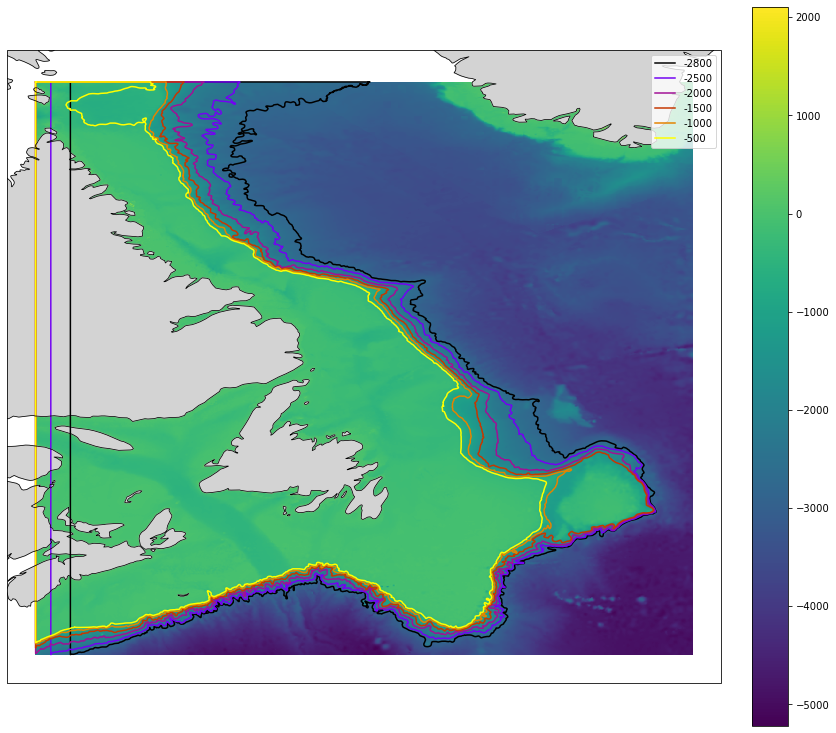

In [20]:
def gen_color(cmap,n,reverse=False):
    '''Generates n distinct color from a given colormap. Function is a slightly modified version of one in the
    mycolorpy package: https://github.com/binodbhttr/mycolorpy/blob/master/usage_example.ipynb
    Parameters
    ----------
    cmap (str): The name of the colormap you want to use. Examples for distinct objects: gnuplot, brg, jet, turbo.    
    n (int): Number of colors you want from the cmap you entered.
    reverse (bool): False by default. Set it to True if you want the cmap result to be reversed.
    Returns
    -------
    colorlist(list): A list with hex values of colors.
    '''
    c_map = plt.cm.get_cmap(str(cmap)) # select the desired cmap
    arr=np.linspace(0,1,n) #create a list with numbers from 0 to 1 with n items
    colorlist=list()
    for c in arr:
        rgba=c_map(c) #select the rgba value of the cmap at point c which is a number between 0 to 1
        clr=colors.rgb2hex(rgba) #convert to hex
        colorlist.append(str(clr)) # create a list of these colors
    if reverse==True:
        colorlist.reverse()
    return colorlist


def load_polygon_tuples(polyfile, area):
    f = open(polyfile, 'r')
    ym = yaml.load(f, Loader=yaml.FullLoader)
    ym_tuples = convert_coords_to_tuples(ym['polygon_coords'][area])
    return ym_tuples

drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/"
bathydir = os.path.join(drifter_dir, 'bathymetry')

fig = plt.figure(figsize=(14, 14), facecolor='white')
ax = plt.axes(projection=ccrs.PlateCarree())

#bathy = os.path.join(bathydir, 'ETOPO1_Bed_g_gmt4.grd')
bathy = os.path.join(bathydir, 'bathy_subset.nc')
with xr.load_dataset(bathy) as ds:
    deps = ds.z.values
    lons = ds.x.values
    lats = ds.y.values
mesh = plt.pcolormesh(lons, lats, deps)
plt.colorbar(mesh, fraction=0.046, pad=0.04)

ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75, zorder=4)

levels = [-2800, -2500, -2000, -1500, -1000, -500]
colorlist = gen_color('gnuplot', len(levels), reverse=False)
for level, lcolor in zip(levels, colorlist):
    polyfile = os.path.join(bathydir, ('contour_' + str(level).replace('-','') + '_polygons.yaml'))
    poly = load_polygon_tuples(polyfile, ('contour_' + str(level).replace('-','')))
    plt.plot(list(zip(*poly))[0], list(zip(*poly))[1], color=lcolor, label=str(level))

#plt.plot(list(zip(*coords))[1], list(zip(*coords))[0], 'r')
ax.legend()

#get x-axis and y-axis limits
minlon, maxlon, minlat, maxlat = plt.axis()
ax.set_extent([minlon-1, maxlon+1, minlat-1, maxlat+1])

figname = 'all_contours.png'
plt.savefig(os.path.join(bathydir, 'plots', 'contours', figname))

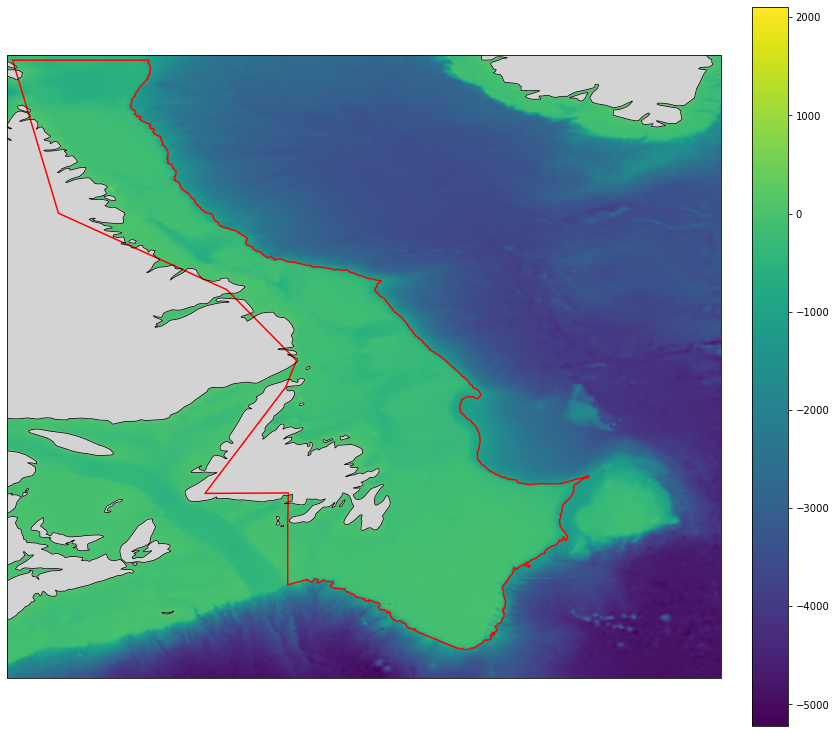

In [21]:
################################################################################################
# to create the merged polygon area: 
################################################################################################

# load the bathy polygon coords (made using create_poly_from_contour)
bathy_polygons_yml_filename = os.path.join(bathydir, 'contour_1000_polygons.yaml')
f = open(bathy_polygons_yml_filename, 'r')
ym_c1000 = yaml.load(f, Loader=yaml.FullLoader)
contour1000 = convert_coords_to_tuples(ym_c1000['polygon_coords']['contour_1000'])

# load the polygons from the OPP drifter report 
OPP_polygons_file = os.path.join(bathydir, 'OPP_drifter_report_regions_NL_LAB_shelves.yml')
OPP_coords = load_polygons(OPP_polygons_file)
OPPpolys = convert_coords_to_tuples(OPP_coords['polygon_coords']['Newfoundland and Labrador'])

# Extract the point values that define the perimeter of the intersection between the two polygons above
ipoly = Polygon(OPPpolys).intersection(Polygon(contour1000))
ilons, ilats = ipoly.exterior.coords.xy
intpoly = list(zip(list(ilons), list(ilats)))

# Add coordinates to a yaml file (in this case the merged polygon boundary)
ym = create_poly_from_coords(os.path.join(bathydir, 'merged_OPP-report_1000m-contour_polygon.yaml'), intpoly)
quick_bathy_plot(etopo, coords=ym['polygon_coords']['intpoly'])